# Setup

In [111]:
%load_ext autoreload
%autoreload 2

# general/plotting
import matplotlib.pyplot as plt

# gee functions
import ee
import folium
import geemap
import gee_utils
# Authenticate to Earth Engine
ee.Authenticate()
# Initialize Earth Engine instance
ee.Initialize(project="reeftruth")
# mount google drive
drive.mount('/content/drive')
#!!! (for readme)
# https://stackoverflow.com/questions/78374548/no-authentication-box-appears-when-authenticating-google-earth-engine-gee-pyth

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


NameError: name 'drive' is not defined

In [70]:
# Add Earth Engine drawing method to folium.
folium.Map.add_ee_layer = gee_utils.add_ee_layer

# Vis params and AOIs

In [71]:
### Visualisation params
# harmonized sentinel-2 bands
sVisParams = {
  "min": 0,
  "max": 3000,
  "gamma": 1.5,
  "bands": ["B4", "B3", "B2"]
}
# Define the bands to be used
sBands = ["B2", "B3", "B4", "B5", "B6", "B7", "B8", "B8A"]
# PRSIM benthic classes
prismVisParams = {
  "min": 0,
  "max": 1,
  "color": ["red", "green", "blue"],
};

### AOI
# Define bounds
swains_bounds = [[151.9006776532874, -22.425424797331246],
          [152.83451554391243, -22.425424797331246],
          [152.83451554391243, -21.408761467649015],
          [151.9006776532874, -21.408761467649015],
          [151.9006776532874, -22.425424797331246]]
swains_aoi = ee.Geometry.Polygon(swains_bounds)


# Sentinel basemap

In [72]:
import ee
import geemap

# set AOI
aoi_geom = swains_aoi

# Define the Sentinel-2 Image Collection and Cloud Collection
sentinel_collection = ee.ImageCollection("COPERNICUS/S2_HARMONIZED") # Level 1C, 2015-2024
sentinel_collection = ee.ImageCollection("COPERNICUS/S2_SR_HARMONIZED") # Level 2A, 2017-2024
sentinel_clouds = ee.ImageCollection("GOOGLE/CLOUD_SCORE_PLUS/V1/S2_HARMONIZED")

# Filter satellite timeseries for best image
sentinel_colour = sentinel_collection.filterDate("2022-01-01", "2023-01-01") \
    .filterBounds(aoiGeom)  \
    .linkCollection(sentinel_clouds, ["cs_cdf"]) \
    .map(lambda image: image.updateMask(image.select("cs_cdf").gt(0.6)))

composite = sentinel_colour.median()

# Calculate NDWI to mask land
ndwi = composite.expression(
    '(GREEN - NIR) / (GREEN + NIR)',
    {
        'GREEN': composite.select('B3'),
        'NIR': composite.select('B8')
    }
)

# Sunglint correction and water mask
water_image = composite.updateMask(ndwi.gt(0.1)).select(['B4', 'B3', 'B2']).subtract(composite.select('B8'))
sunglint_correction = composite.select(['B4', 'B3', 'B2']).subtract(composite.select('B8'))

# Add layers to the map
Map = geemap.Map(height='1000px')
Map.addLayer(water_image.clip(aoiGeom), sVisParams, '(NDWI) satellite-derived land mask')
Map.addLayer(composite.clip(aoiGeom), sVisParams, 'sentinel composite')
Map.addLayer(sunglint_correction.clip(aoiGeom), sVisParams, 'tow R', False)

# Uncomment below to use the RF-based mask
# masked_img = gee_utils.landmask(composite.clip(aoiGeom))
# Map.addLayer(masked_img, sVisParams, 'satellite-derived land mask (RF)', False)
# Map

# PRISM data

In [77]:
swains = ee.Image("projects/reeftruth/assets/PRISM/Swains").rename(['coral','algae','sand'])
Map.addLayer(swains, prismVisParams, 'PRISM benthic classes')

In [79]:
# get bands from swains
swains_flight_bounds = swains.get("system:footprint").getInfo().get("coordinates")
out = ee.Geometry.Polygon(swains_flight_bounds)
# create sunglint_correction cropped to swains bounds
swains_aoi_sunglint_correction = sunglint_correction.clip(out)
Map.addLayer(swains_aoi_sunglint_correction, sVisParams, 'tow R (swains bounds)', False)


In [80]:
Map.centerObject(aoiGeom, 11)
Map

Map(bottom=294871.0, center=[-21.91714700361253, 152.36759659859993], controls=(WidgetControl(options=['positi…

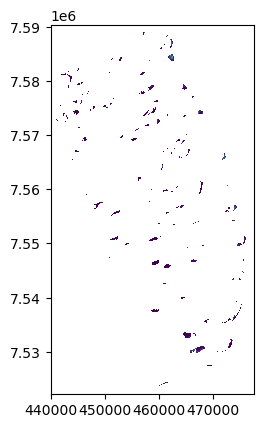

<Axes: >

In [84]:
# investigate swains data from local file
swains_fp = ("/Users/rt582/Library/CloudStorage/OneDrive-UniversityofCambridge/cambridge/phd/reeftruth/data/prism/processed/Swains.tif")
import rasterio as rio
from rasterio import plot as rioplot
swains_tif = rio.open(swains_fp)
rioplot.show(swains_tif)

In [108]:
gee_utils.inspect_tif(swains_tif)

DIMENSIONS | height:  8746 width:  4800
BOUNDS |  BoundingBox(left=439970.9292, bottom=7522167.0671, right=477410.9292, top=7590385.8671)
BANDS | count:  3
DATA TYPE(S) |  {1: 'float32', 2: 'float32', 3: 'float32'}
CRS |  EPSG:32756
TRANSFORM |  | 7.80, 0.00, 439970.93|
| 0.00,-7.80, 7590385.87|
| 0.00, 0.00, 1.00|


In [116]:
band_dict = gee_utils.process_tif(swains_tif)
band1, band2, band3 = band_dict["b1"], band_dict["b2"], band_dict["b3"]

Text(0.5, 1.0, 'algae')

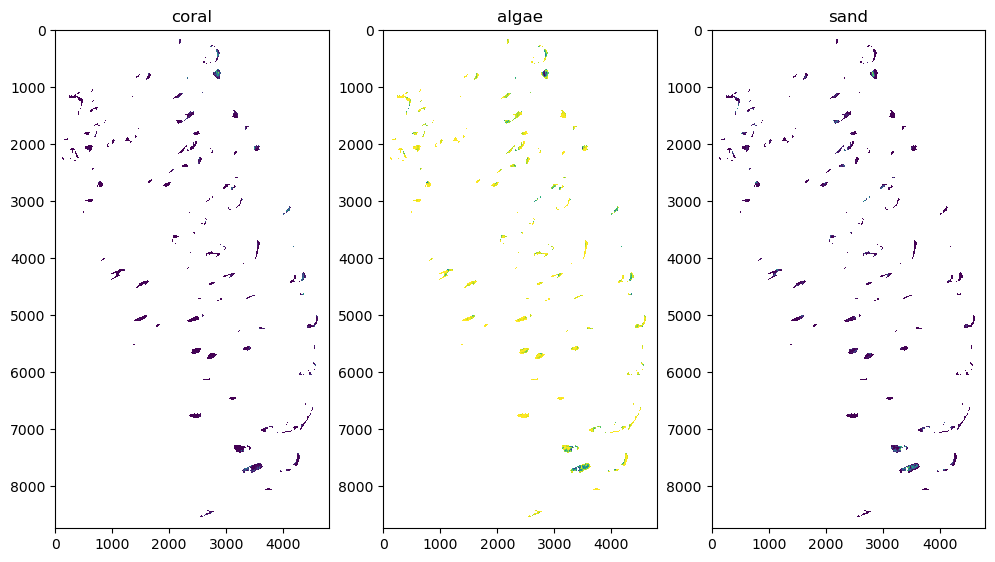

In [123]:
f, ax = plt.subplots(ncols=3, figsize=(12, 8))
ax[0].imshow(band1, cmap='viridis', vmin=0, vmax=1)
ax[2].set_title('sand')
ax[1].imshow(band2, cmap='viridis', vmin=0, vmax=1)
ax[0].set_title('coral')
ax[2].imshow(band3, cmap='viridis', vmin=0, vmax=1)
ax[1].set_title('algae')


In [ ]:
# TODO:
# - add depth retrieval
# - mask depth (else may see classes which haven't been classified)
# - add depth profile to map
# - split into test and train sets
# - train ee RF model
# - export relevant imagery to drive
# - train sklearn RF model locally (https://geemap.org/notebooks/46_local_rf_training/)
# - transfer model to EE